In [1]:
import gc

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from shared.local_path import *
from shared.utils import *

In [2]:
TRAIN_IMAGE_PATH = r'E:\Skripsi\data\temp\train'

In [3]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(28709, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\Skripsi\data\temp\train\angry\Training_1011...,angry
1,E:\Skripsi\data\temp\train\angry\Training_1012...,angry
2,E:\Skripsi\data\temp\train\angry\Training_1013...,angry
3,E:\Skripsi\data\temp\train\angry\Training_1016...,angry
4,E:\Skripsi\data\temp\train\angry\Training_1021...,angry


In [4]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])

In [5]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(
        lambda x: preprocess_image2(x, (100, 100), rescale=1/255., augment=True))


In [6]:
(train_df.label_encoded.value_counts())

label_encoded
3    7215
4    4965
5    4830
2    4097
0    3995
6    3171
1     436
Name: count, dtype: int64

In [7]:
# Image Data
# train_df = train_df.sample(frac=1, random_state=19).reset_index(drop=True)
train_df, img_val_df = train_test_split(train_df, test_size=.2, random_state=100, shuffle=True)

In [8]:
x_img_train = np.stack(train_df['data'].values)
y_img_train = np.array(train_df['label_encoded'].values)

x_img_val = np.stack(img_val_df['data'].values)
y_img_val = np.array(img_val_df['label_encoded'].values)

In [9]:
del train_df, img_val_df

In [10]:
base = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(100, 100, 3),
    pooling='max'
)

for layer in base.layers:
    layer.trainable = False


In [11]:
input_image = tf.keras.Input(shape=(100, 100, 3), name='input_image')

left = base(input_image)
# left = tf.keras.layers.Dropout(.5)(left)
# left = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, name='batch_norm_x')(left)
# left = tf.keras.layers.BatchNormalization()(left)
left = tf.keras.layers.Dense(512, activation='relu')(left)
# left = tf.keras.layers.BatchNormalization()(left)
# left = tf.keras.layers.Dense(64, activation='relu')(left)
# left = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
#                              activity_regularizer=tf.keras.regularizers.l1(0.006),
#                              bias_regularizer=tf.keras.regularizers.l1(0.006),
#                              )(left)
out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(left)

model = tf.keras.models.Model(input_image, out1)

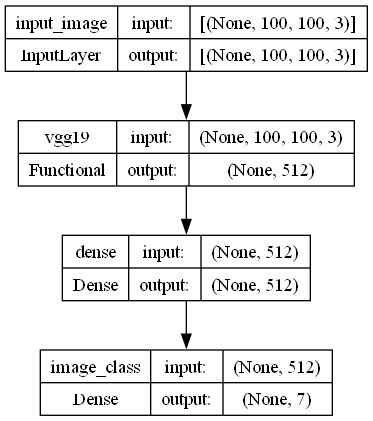

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
x_img_train[0].shape

(100, 100, 3)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics='accuracy',
)

In [15]:
tf.keras.backend.clear_session()
gc.collect()

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [16]:
history = model.fit(
    x=x_img_train,
    y=y_img_train,
    validation_data=(
        x_img_val,
        y_img_val
    ),
    callbacks=[lr_scheduler],
    epochs=50,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


Epoch 1/50
358/358 [==============================] - 32s 70ms/step - loss: 1.6021 - accuracy: 0.3716 - val_loss: 1.5424 - val_accuracy: 0.3915 - lr: 0.0010
Epoch 2/50
358/358 [==============================] - 26s 67ms/step - loss: 1.5001 - accuracy: 0.4222 - val_loss: 1.5087 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 3/50
358/358 [==============================] - 24s 68ms/step - loss: 1.4700 - accuracy: 0.4386 - val_loss: 1.4706 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 4/50
358/358 [==============================] - 24s 67ms/step - loss: 1.4400 - accuracy: 0.4462 - val_loss: 1.4861 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/50
358/358 [==============================] - 24s 67ms/step - loss: 1.4283 - accuracy: 0.4496 - val_loss: 1.4947 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 6/50
358/358 [==============================] - 24s 68ms/step - loss: 1.4064 - accuracy: 0.4612 - val_loss: 1.4558 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 7/50
358/358 [==============================] - 24s 

In [17]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [18]:
plot_and_save('loss', history, 'Loss', 'image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

In [19]:
model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_val) // BATCH_SIZE)

89/89 - 5s - loss: 1.4072 - accuracy: 0.4637 - 5s/epoch - 51ms/step


[1.4071853160858154, 0.46365872025489807]

In [20]:
predictions = model.predict(x_img_val)
predictions = np.argmax(predictions, axis=1)

classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

180/180 [==============================] - 6s 29ms/step
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


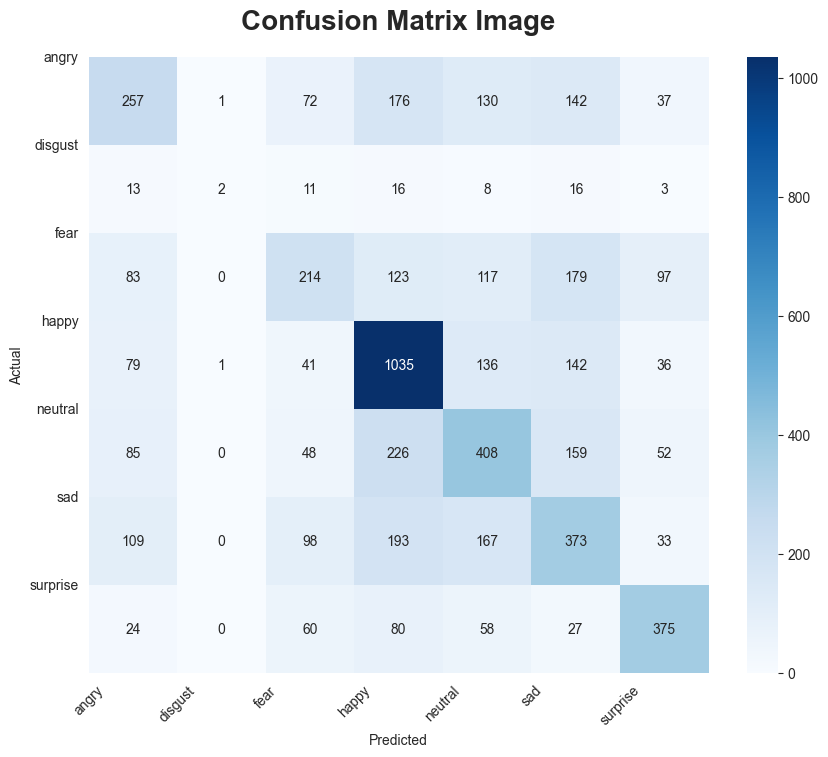

In [21]:
cm = confusion_matrix(y_img_val, predictions)
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_image.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print(classification_report(y_img_val, predictions))

              precision    recall  f1-score   support

           0       0.40      0.32      0.35       815
           1       0.50      0.03      0.05        69
           2       0.39      0.26      0.32       813
           3       0.56      0.70      0.62      1470
           4       0.40      0.42      0.41       978
           5       0.36      0.38      0.37       973
           6       0.59      0.60      0.60       624

    accuracy                           0.46      5742
   macro avg       0.46      0.39      0.39      5742
weighted avg       0.45      0.46      0.45      5742

